### Carregamento dos dados

In [1]:
import torch
import gc
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

from src.data import LOCCADataset  # noqa: E402, F401

##### Transformações

In [2]:
import albumentations as A

# Veja: https://albumentations.ai/docs/3-basic-usage/semantic-segmentation/
# De acordo com isso, ao especificar os parametros image e mask para transform, 
# algumas transformações que só fazem sentido serem aplicadas em imagens não serão
# aplicadas nas máscaras.

# Talvez, devido o pré-procesamento, não faça sentido o uso de transformações de intensidades dos pixels
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
])


test_transform = A.Compose([
    # A.Normalize(mean=(0.5,), std=(0.5,)),
])

#### Instanciação do Dataset

In [3]:
import torch
from torch.utils.data import DataLoader

train_dataset = LOCCADataset(
    ROOT_DIR / 'datasets/locca/pngs_preprocessed/train',
    train_transform
)

val_dataset = LOCCADataset(
    ROOT_DIR / 'datasets/locca/pngs_preprocessed/test',
    test_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,  #TODO: isso pode atrapalhar a avaliação de desempenho? Imagino que sim!
    num_workers=8,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8
)


### Visualização

In [4]:
loader = iter(train_loader)

In [5]:
batch = next(loader)
print(batch['volume'].shape)

torch.Size([8, 512, 512])


In [6]:
import random


def visualize_batch_overlay(batch, n_samples=4, alpha=0.5):
    volume = batch["volume"]
    mask = batch["mask"]

    B = volume.shape[0]
    idxs = random.sample(range(B), min(n_samples, B))

    fig, axs = plt.subplots(len(idxs), 3, figsize=(6, 3 * len(idxs)))

    if len(idxs) == 1:
        axs = [axs]

    for lin, i in zip(axs, idxs):
        ct = volume[i].cpu().numpy()
        m = mask[i].cpu().numpy()

        lin[0].imshow(ct, cmap="gray")
        lin[0].set_title(f"slice [{i}]\nftype: {volume[i].cpu().dtype}")
        lin[0].axis("off")

        lin[1].imshow(m, cmap="Reds")
        lin[1].set_title(f"mask [{i}]\nvalues: {np.unique(m)}\ndtype: {mask[i].cpu().dtype}")
        lin[1].axis("off")

        lin[2].imshow(ct, cmap="gray")
        lin[2].imshow(m > 0, cmap="Reds", alpha=alpha)
        lin[2].set_title(f"Overlay slice [{i}]")
        lin[2].axis("off")

    plt.tight_layout()
    plt.show()

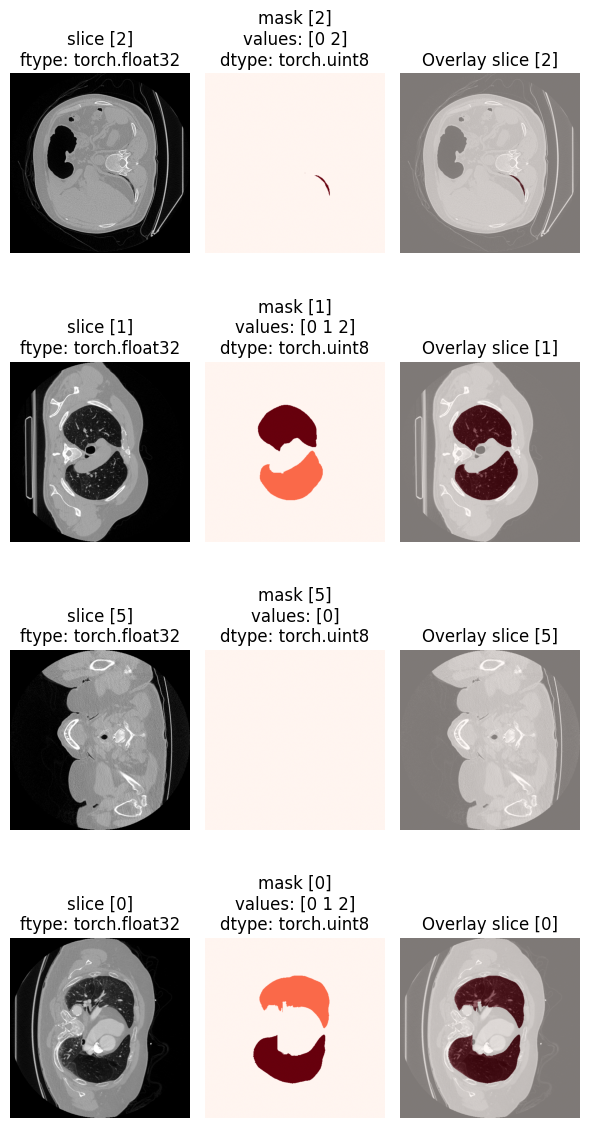

In [7]:
visualize_batch_overlay(batch)

### Linghting Module
Baseado em: https://colab.research.google.com/github/qubvel-org/segmentation_models.pytorch/blob/main/examples/camvid_segmentation_multiclass.ipynb

In [ ]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler


class LOCCAModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        self.number_of_classes = out_classes

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs = []
        # self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        """ Esse é um bloco de código utilizado tanto no treinamento, quanto na
        validação e no teste. """
        image, mask = batch['volume'], batch['mask']
        image = image.unsqueeze(1)

        
        # Plot para DEBUG
        # img_i = image[3]
        # mask_i = mask[3]
        # plt.subplot(121); plt.imshow(img_i.cpu().permute(2, 1, 0)); 
        # plt.subplot(122); plt.imshow(mask_i.cpu().permute(1,0));
        # plt.show()

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, 1, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)


        # Plot para DEBUG
        # img_i = image[3]
        # pred_mask_i = pred_mask[3]
        # plt.subplot(121); plt.imshow(img_i.cpu().permute(2, 1, 0)); plt.axis('off');
        # plt.subplot(122); plt.imshow(pred_mask_i.cpu().permute(1,0)); plt.axis('off');
        # plt.show()



        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()


    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return {
            "optimizer": optimizer,
        }

In [9]:
# 1. Delete as variáveis pesadas (modelo, otimizador, batches)
if 'model' in locals():
    del model
if 'batch' in locals():
    del batch

# 2. Força a coleta de lixo do Python
gc.collect()

# 3. Limpa o cache de memória da GPU
torch.cuda.empty_cache()

# Opcional: verifique quanta memória sobrou
print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Memória alocada: 0.00 MB


In [10]:
model = LOCCAModel("UnetPlusPlus", "mobilenet_v2", in_channels=1, out_classes=3)

In [11]:
torch.set_float32_matmul_precision('medium')

trainer = pl.Trainer(max_epochs=3, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/duque/Projects/tcc/meu_tcc/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
vis_loader = iter(val_loader)

In [13]:
data = next(vis_loader)

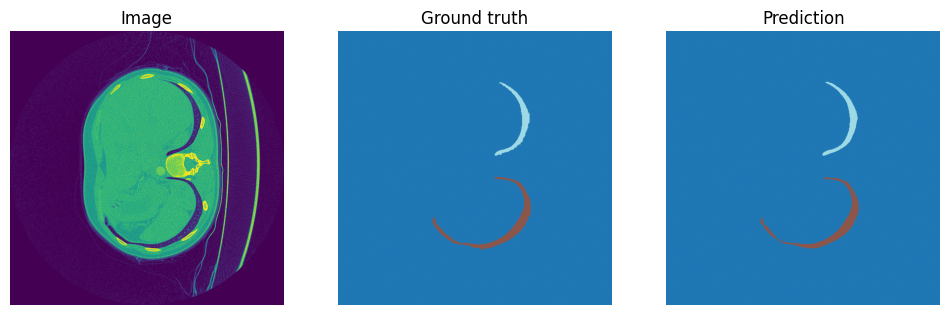

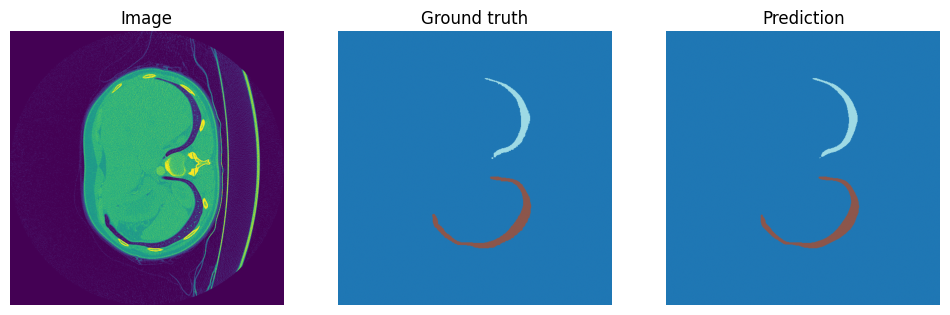

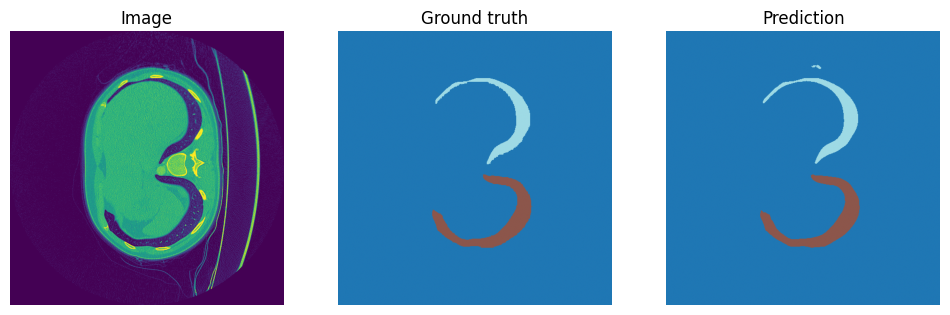

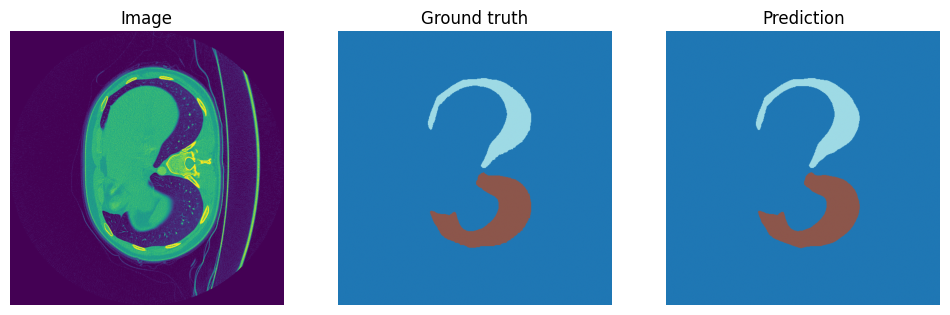

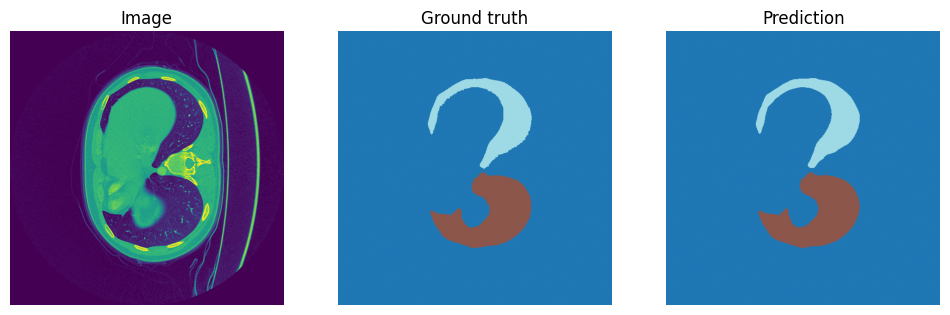

In [14]:
import numpy as np


# Fetch a batch from the test loader
images, masks = data['volume'].unsqueeze(1), data['mask']
# Switch the model to evaluation mode
with torch.inference_mode():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break

### Pendências:

* Código para KFold;
* Pensar fluxo comparativo;